# Lab: Recurrent Network Architectures

&emsp; In this lab, we decide to constract Recurrent Network Architectures and perform prediction, or called classification, tasks base on the Spam Assassin dataset from Kaggle https://www.kaggle.com/datasets/ganiyuolalekan/spam-assassin-email-classification-dataset. The original dataset was collected from https://spamassassin.apache.org/old/publiccorpus/ and published on Kaggle by Ganiyu Olalekan. This dataset contains over five thousand unique email messages and classification results of whether each message is spam or not. There  It is suitable to test the performence of spam filtering system using this dataset according to the publisher.

# 1. Preparation

## 1.1 Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('spam_assassin.csv')
print(df.head())
print(df.info())

                                                text  target
0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...       0
1  From gort44@excite.com Mon Jun 24 17:54:21 200...       1
2  From fork-admin@xent.com Mon Jul 29 11:39:57 2...       1
3  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...       1
4  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5796 non-null   object
 1   target  5796 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.7+ KB
None


In [3]:
def ReserveKernalCharacters(text, remove_digits=True):
    reserved_part = r'[^a-zA-z0-9\s]'
    text = re.sub(reserved_part, '', text)
    
    return text

In [4]:
y = df['target']
X = df['text'].apply(ReserveKernalCharacters)

In [5]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 178354 unique tokens. Distilled to 178354 top words.
Shape of data tensor: (5796, 1000)
Shape of label tensor: (5796, 2)
178354
CPU times: total: 5.34 s
Wall time: 6.83 s


&emsp; We have used Tokenizer from Keras to achieve tokenization in our dataset. Every text data will be modified to a sequence of integers or a vector in the form of binary values with coefficients for each token by Tokenizer. It could help machine to interpret the original text data and perform classification tasks.<br>
&emsp; The pad_sequences function also is implemented in our model. This function can pad sequences which produced by Tokenizer to the same length by converting the integer sequences into a two dimension Numpy array of shape. It could eliminate the protential risks caused by various lengths of text data.

## 1.2 Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance:

&emsp; For common user, the accuracy is the most understandable metric to judge the prediction performance of our algorithm. However, we would said the area under the ROC (Receiver Operating Characteristics) curve is the better evaluation metric for our algorithm. Because the cost of False Positive or False Negative produced by spam filtering system is considered to be significant.<br>
&emsp; The False Positive represents that our algorithm has wrongly classified the emails that are not spam into spam. We could consider a scenario. In this scenario, the spam filtering system classifies the email about interview invitation sent by a specific company to one of their candidates into spam by mistake, and prevents the candidate from receiving the interview invitation. It may cause the candidate to lose the opportunity to obtain a good job and the company to lose a potential good employee in the future. That's why the cost of False Positive is considered to be significant.<br>
&emsp; The False Negative represents that our algorithm has wrongly classified the emails that are spam into not spam. Now consider another scenario. In this scenario, a candidate is waiting for the reply from company. Then he realizes the email his just received is spam. He may feel disappointed. It seems there is not a significant cost of producing False Positive. However, on the second throught, what the point of our spam filtering algorithm if it can not identify spam.<br>
&emsp; The curve diagram of ROC represents the relationship between the True Positive and the False Positive. And the area under the ROC curve represents the essentially averages accuracy base on all prediction results. Using it as evaluation metric could minimize the cost of False Positive or False Negative.

## 1.3 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice:

&emsp; According to the publisher, this dataset contains four thousand emails which are not spam. And the number of spams stored in this dataset is less than two thousand. It is obvious that this Spam Assassin dataset is unbalanced. As we know, an imbalance dataset may result in potential risks when we train model. In order to eliminate the negetive influence of imbalance, we decide to import train_test_split package to perform the train and test partitioning of the dataset. Because train_test_split package is able to maintain the percentage of each class in the dataset and randomly split into train and test datasets with 8:2 ratio.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2, random_state=7, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4636, 1000), (1160, 1000), (4636, 2), (1160, 2))

# 2. Modeling

## 2.1 Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Alternatively, you may also choose one recurrent network and one convolutional network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them:

Using a pre-trained embedding:

In [7]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.100d.txt', 'r',encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (178355, 100) 
 Total words found: 30825 
 Percentage: 17.2829469316812
CPU times: total: 10.8 s
Wall time: 11.8 s


In [8]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

LSTM Model 1:

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

NUM_CLASSES = 2
epochs_number = 6
batch_size_number = 32
lstm_1 = Sequential()
lstm_1.add(embedding_layer)
lstm_1.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
lstm_1.add(Dense(NUM_CLASSES, activation='sigmoid'))
lstm_1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         17835500  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 17,916,102
Trainable params: 80,602
Non-trainable params: 17,835,500
_________________________________________________________________
None


In [10]:
history_lstm_1 = []
tmp = lstm_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs_number, batch_size=batch_size_number)
history_lstm_1.append( tmp )

Epoch 1/6
145/145 [==============================] - 333s 2s/step - loss: 0.3240 - accuracy: 0.8693 - val_loss: 0.1558 - val_accuracy: 0.9466
Epoch 2/6
145/145 [==============================] - 354s 2s/step - loss: 0.1805 - accuracy: 0.9325 - val_loss: 0.1241 - val_accuracy: 0.9543
Epoch 3/6
145/145 [==============================] - 352s 2s/step - loss: 0.1469 - accuracy: 0.9523 - val_loss: 0.1010 - val_accuracy: 0.9672
Epoch 4/6
145/145 [==============================] - 357s 2s/step - loss: 0.1133 - accuracy: 0.9612 - val_loss: 0.1267 - val_accuracy: 0.9621
Epoch 5/6
145/145 [==============================] - 364s 3s/step - loss: 0.1399 - accuracy: 0.9588 - val_loss: 0.0775 - val_accuracy: 0.9741
Epoch 6/6
145/145 [==============================] - 367s 3s/step - loss: 0.0863 - accuracy: 0.9733 - val_loss: 0.1019 - val_accuracy: 0.9621


In [11]:
from sklearn import metrics as mt
import seaborn as sns

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    y_test_ohe = np.argmax(y_test, axis=1)
    acc = mt.precision_score(y_test_ohe,yhat)
    cm = mt.confusion_matrix(y_test_ohe,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    ax = sns.heatmap(cm, annot=True, fmt='.2f')
    ax.set_ylim([2, 0])
    plt.title(title_text+'{:.4f}'.format(acc))

37/37 [==============================] - 10s 252ms/step


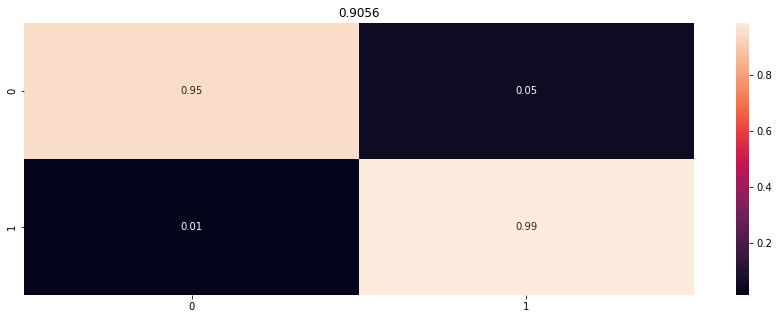

In [12]:
summarize_net(lstm_1, X_test, y_test)

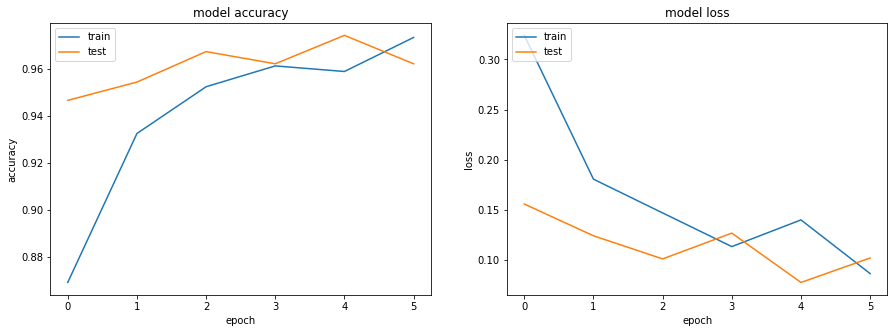

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history_lstm_1])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
y_hat_lstm_1=lstm_1.predict(X_test)
lstm_1_acc = mt.accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_hat_lstm_1, axis=1))
print(lstm_1_acc)

37/37 [==============================] - 9s 250ms/step
0.9620689655172414


LSTM Model 2:

&emsp; Compare to LSTM Model 1, we have add an extra recurrent chain to LSTM Model 2.

In [15]:
lstm_2 = Sequential()
lstm_2.add(embedding_layer)
lstm_2.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_2.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
lstm_2.add(Dense(NUM_CLASSES, activation='sigmoid'))
lstm_2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(lstm_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         17835500  
                                                                 
 lstm_1 (LSTM)               (None, 1000, 100)         80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 17,996,502
Trainable params: 161,002
Non-trainable params: 17,835,500
_________________________________________________________________
None


In [16]:
history_lstm_2 = []
tmp = lstm_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs_number, batch_size=batch_size_number)
history_lstm_2.append( tmp )

Epoch 1/6
145/145 [==============================] - 961s 7s/step - loss: 0.3226 - accuracy: 0.8648 - val_loss: 0.1611 - val_accuracy: 0.9371
Epoch 2/6
145/145 [==============================] - 963s 7s/step - loss: 0.1768 - accuracy: 0.9362 - val_loss: 0.0993 - val_accuracy: 0.9664
Epoch 3/6
145/145 [==============================] - 987s 7s/step - loss: 0.1264 - accuracy: 0.9575 - val_loss: 0.0996 - val_accuracy: 0.9698
Epoch 4/6
145/145 [==============================] - 1002s 7s/step - loss: 0.1019 - accuracy: 0.9659 - val_loss: 0.0769 - val_accuracy: 0.9716
Epoch 5/6
145/145 [==============================] - 1021s 7s/step - loss: 0.0815 - accuracy: 0.9737 - val_loss: 0.0806 - val_accuracy: 0.9759
Epoch 6/6
145/145 [==============================] - 1040s 7s/step - loss: 0.0723 - accuracy: 0.9754 - val_loss: 0.0640 - val_accuracy: 0.9828


37/37 [==============================] - 18s 467ms/step


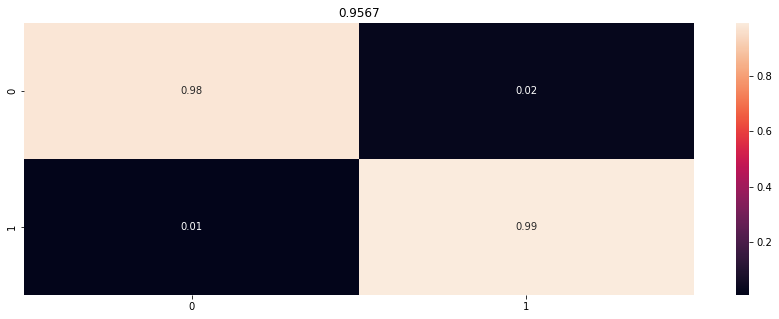

In [17]:
summarize_net(lstm_2, X_test, y_test)

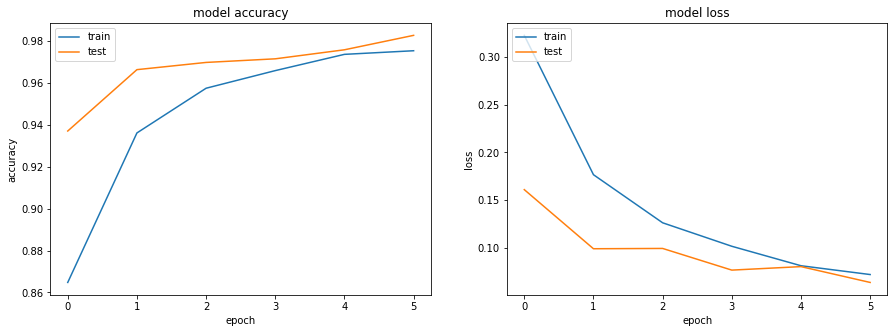

In [18]:
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history_lstm_2])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
y_hat_lstm_2=lstm_2.predict(X_test)
lstm_2_acc = mt.accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_hat_lstm_2, axis=1))
print(lstm_2_acc)

37/37 [==============================] - 17s 463ms/step
0.9827586206896551


GRU Model 1:

In [20]:
gru_1 = Sequential()
gru_1.add(embedding_layer)
gru_1.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
gru_1.add(Dense(NUM_CLASSES, activation='sigmoid'))
gru_1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(gru_1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         17835500  
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 17,896,302
Trainable params: 60,802
Non-trainable params: 17,835,500
_________________________________________________________________
None


In [21]:
history_gru_1 = []
tmp = gru_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs_number, batch_size=batch_size_number)
history_gru_1.append( tmp )

Epoch 1/6
145/145 [==============================] - 301s 2s/step - loss: 0.3415 - accuracy: 0.8604 - val_loss: 0.1888 - val_accuracy: 0.9353
Epoch 2/6
145/145 [==============================] - 299s 2s/step - loss: 0.2009 - accuracy: 0.9262 - val_loss: 0.0980 - val_accuracy: 0.9655
Epoch 3/6
145/145 [==============================] - 301s 2s/step - loss: 0.1279 - accuracy: 0.9577 - val_loss: 0.0712 - val_accuracy: 0.9759
Epoch 4/6
145/145 [==============================] - 300s 2s/step - loss: 0.0995 - accuracy: 0.9676 - val_loss: 0.0878 - val_accuracy: 0.9724
Epoch 5/6
145/145 [==============================] - 299s 2s/step - loss: 0.0774 - accuracy: 0.9735 - val_loss: 0.0652 - val_accuracy: 0.9784
Epoch 6/6
145/145 [==============================] - 300s 2s/step - loss: 0.0612 - accuracy: 0.9784 - val_loss: 0.0634 - val_accuracy: 0.9836


37/37 [==============================] - 9s 231ms/step


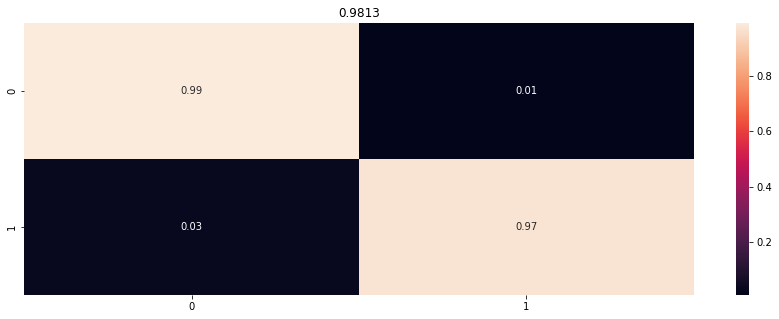

In [22]:
summarize_net(gru_1, X_test, y_test)

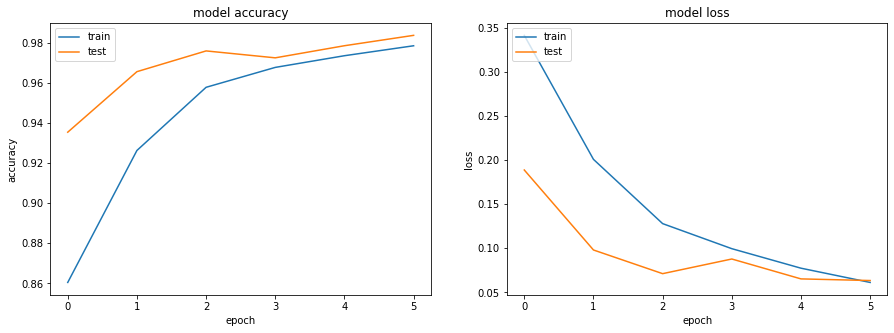

In [23]:
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history_gru_1])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
y_hat_gru_1=gru_1.predict(X_test)
gru_1_acc = mt.accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_hat_gru_1, axis=1))
print(gru_1_acc)

37/37 [==============================] - 9s 231ms/step
0.9836206896551725


GRU Model 2:

&emsp; Compare to GRU Model 1, we also have add an extra recurrent chain to GRU Model 2 like we did to LSTM Model 2.

In [25]:
gru_2 = Sequential()
gru_2.add(embedding_layer)
gru_2.add(GRU(100,dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_2.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
gru_2.add(Dense(NUM_CLASSES, activation='sigmoid'))
gru_2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(gru_2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         17835500  
                                                                 
 gru_1 (GRU)                 (None, 1000, 100)         60600     
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 17,956,902
Trainable params: 121,402
Non-trainable params: 17,835,500
_________________________________________________________________
None


In [26]:
history_gru_2 = []
tmp = gru_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs_number, batch_size=batch_size_number)
history_gru_2.append( tmp )

Epoch 1/6
145/145 [==============================] - 813s 6s/step - loss: 0.3530 - accuracy: 0.8611 - val_loss: 0.2414 - val_accuracy: 0.9086
Epoch 2/6
145/145 [==============================] - 839s 6s/step - loss: 0.1813 - accuracy: 0.9318 - val_loss: 0.0908 - val_accuracy: 0.9750
Epoch 3/6
145/145 [==============================] - 828s 6s/step - loss: 0.1281 - accuracy: 0.9547 - val_loss: 0.0842 - val_accuracy: 0.9724
Epoch 4/6
145/145 [==============================] - 829s 6s/step - loss: 0.0910 - accuracy: 0.9707 - val_loss: 0.0805 - val_accuracy: 0.9759
Epoch 5/6
145/145 [==============================] - 832s 6s/step - loss: 0.0778 - accuracy: 0.9730 - val_loss: 0.0876 - val_accuracy: 0.9733
Epoch 6/6
145/145 [==============================] - 835s 6s/step - loss: 0.0675 - accuracy: 0.9789 - val_loss: 0.0665 - val_accuracy: 0.9836


37/37 [==============================] - 20s 537ms/step


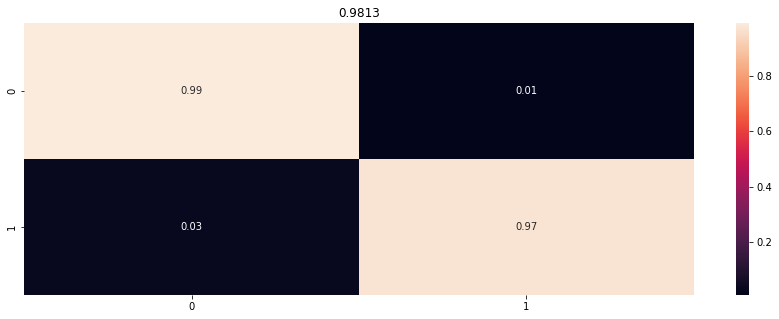

In [27]:
summarize_net(gru_2, X_test, y_test)

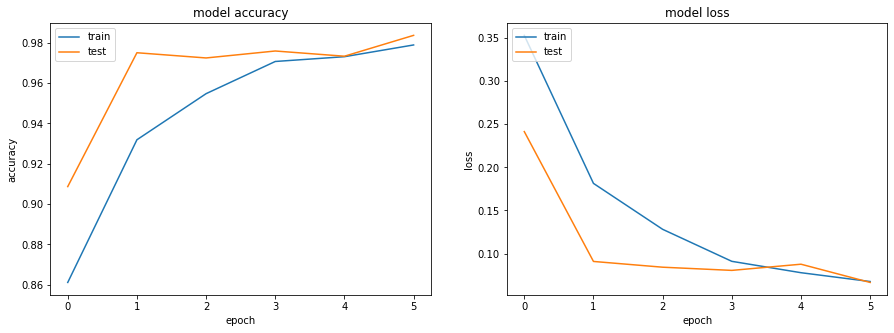

In [28]:
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history_gru_2])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
y_hat_gru_2=gru_2.predict(X_test)
gru_2_acc = mt.accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_hat_gru_2, axis=1))
print(gru_2_acc)

37/37 [==============================] - 19s 525ms/step
0.9836206896551725


&emsp; As we can see from the accuracy results outputed by accuracy_score function from metric class, LSTM model 1 has obtains 96.2 percent accuracy, LSTM model 2 has obtains about 98.3 percent accuracy, and both GRU Model 1 and 2 have obtain about 98.4 percent accuracy.<br>
&emsp; In conclusion, the GRU Model could perform better prediction that LSTM Model. The performance of LSTM Model could be improved by adding extra rerecurrent chains. On the contrary, the performance of GRU Model will not be affected by adding adding extra rerecurrent chains.

## 2.3 Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior:

In [30]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

lw = 2

def ROCArea(y_test_, y_proba_):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = NUM_CLASSES
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_[:, i], y_proba_[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_.ravel(), y_proba_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, roc_auc

37/37 [==============================] - 19s 521ms/step


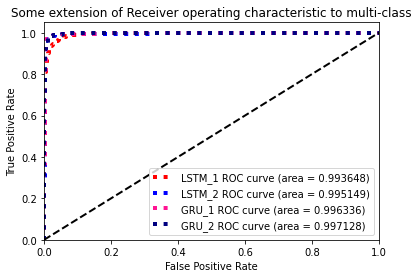

In [33]:
y_lstm_1 = lstm_1.predict(X_test)
y_lstm_2 = lstm_2.predict(X_test)
y_gru_1 = gru_1.predict(X_test)
y_gru_2 = gru_2.predict(X_test)

fpr_1_1, tpr_1_1, roc_auc_1_1 = ROCArea(y_test, y_lstm_1)
fpr_1_2, tpr_1_2, roc_auc_1_2 = ROCArea(y_test, y_lstm_2)
fpr_2_1, tpr_2_1, roc_auc_2_1 = ROCArea(y_test, y_gru_1)
fpr_2_2, tpr_2_2, roc_auc_2_2 = ROCArea(y_test, y_gru_2)

plt.figure(1)
plt.plot(fpr_1_1["micro"], tpr_1_1["micro"],
         label='LSTM_1 ROC curve (area = {0:0.6f})'
               ''.format(roc_auc_1_1["micro"]),
         color='red', linestyle=':', linewidth=4)

plt.plot(fpr_1_2["micro"], tpr_1_2["micro"],
         label='LSTM_2 ROC curve (area = {0:0.6f})'
               ''.format(roc_auc_1_2["micro"]),
         color='blue', linestyle=':', linewidth=4)

plt.plot(fpr_2_1["micro"], tpr_2_1["micro"],
         label='GRU_1 ROC curve (area = {0:0.6f})'
               ''.format(roc_auc_2_1["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_2_2["micro"], tpr_2_2["micro"],
         label='GRU_2 ROC curve (area = {0:0.6f})'
               ''.format(roc_auc_2_2["micro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [32]:
print(f'LSTM 1 accuracy is: {lstm_1_acc}')
print(f'LSTM 2 accuracy is: {lstm_2_acc}')
print(f'GRU 1 accuracy is: {gru_1_acc}')
print(f'GRU 2 accuracy is: {gru_2_acc}')

LSTM 1 accuracy is: 0.9620689655172414
LSTM 2 accuracy is: 0.9827586206896551
GRU 1 accuracy is: 0.9836206896551725
GRU 2 accuracy is: 0.9836206896551725


&emsp; Only accoring to the accuracy outputs above, the two GRU Models have obtained the better performance than the two LSTM Models. Because the prediction accuracy outputs of two GRU Models are close to 98.4 percent, yet the prediction accuracy output of the best of two LSTM Models just close to 98.3 percent. However, it is hard to determine which GRU Models is better since their accuracy outputs are exactly the same.<br>
&emsp; Now the area under the ROC curve mentioned previously should be taken into consider. As the ROC curve shown above, the ROC curve of GRU Model 1 has occupied about 99.6 percent area, yet the ROC curve of GRU Model 2 has occupied approximately 99.7 percent area. Therefore, we can conduct that the GRU Model 2 is best model for us to implement among all the models we have verified.